Jupyter Notebook

In [2]:
from src import *

In [ ]:
#Initial Parameters
t_obs, x_obs, y_obs = load_data('data/predator-prey-data.csv')
init_cond = [x_obs[0], y_obs[0]]

init_guess = (1.0, 0.5, 1.5, 1.0)
bounds = [(0, 2), (0, 2), (0, 2), (0, 2)]

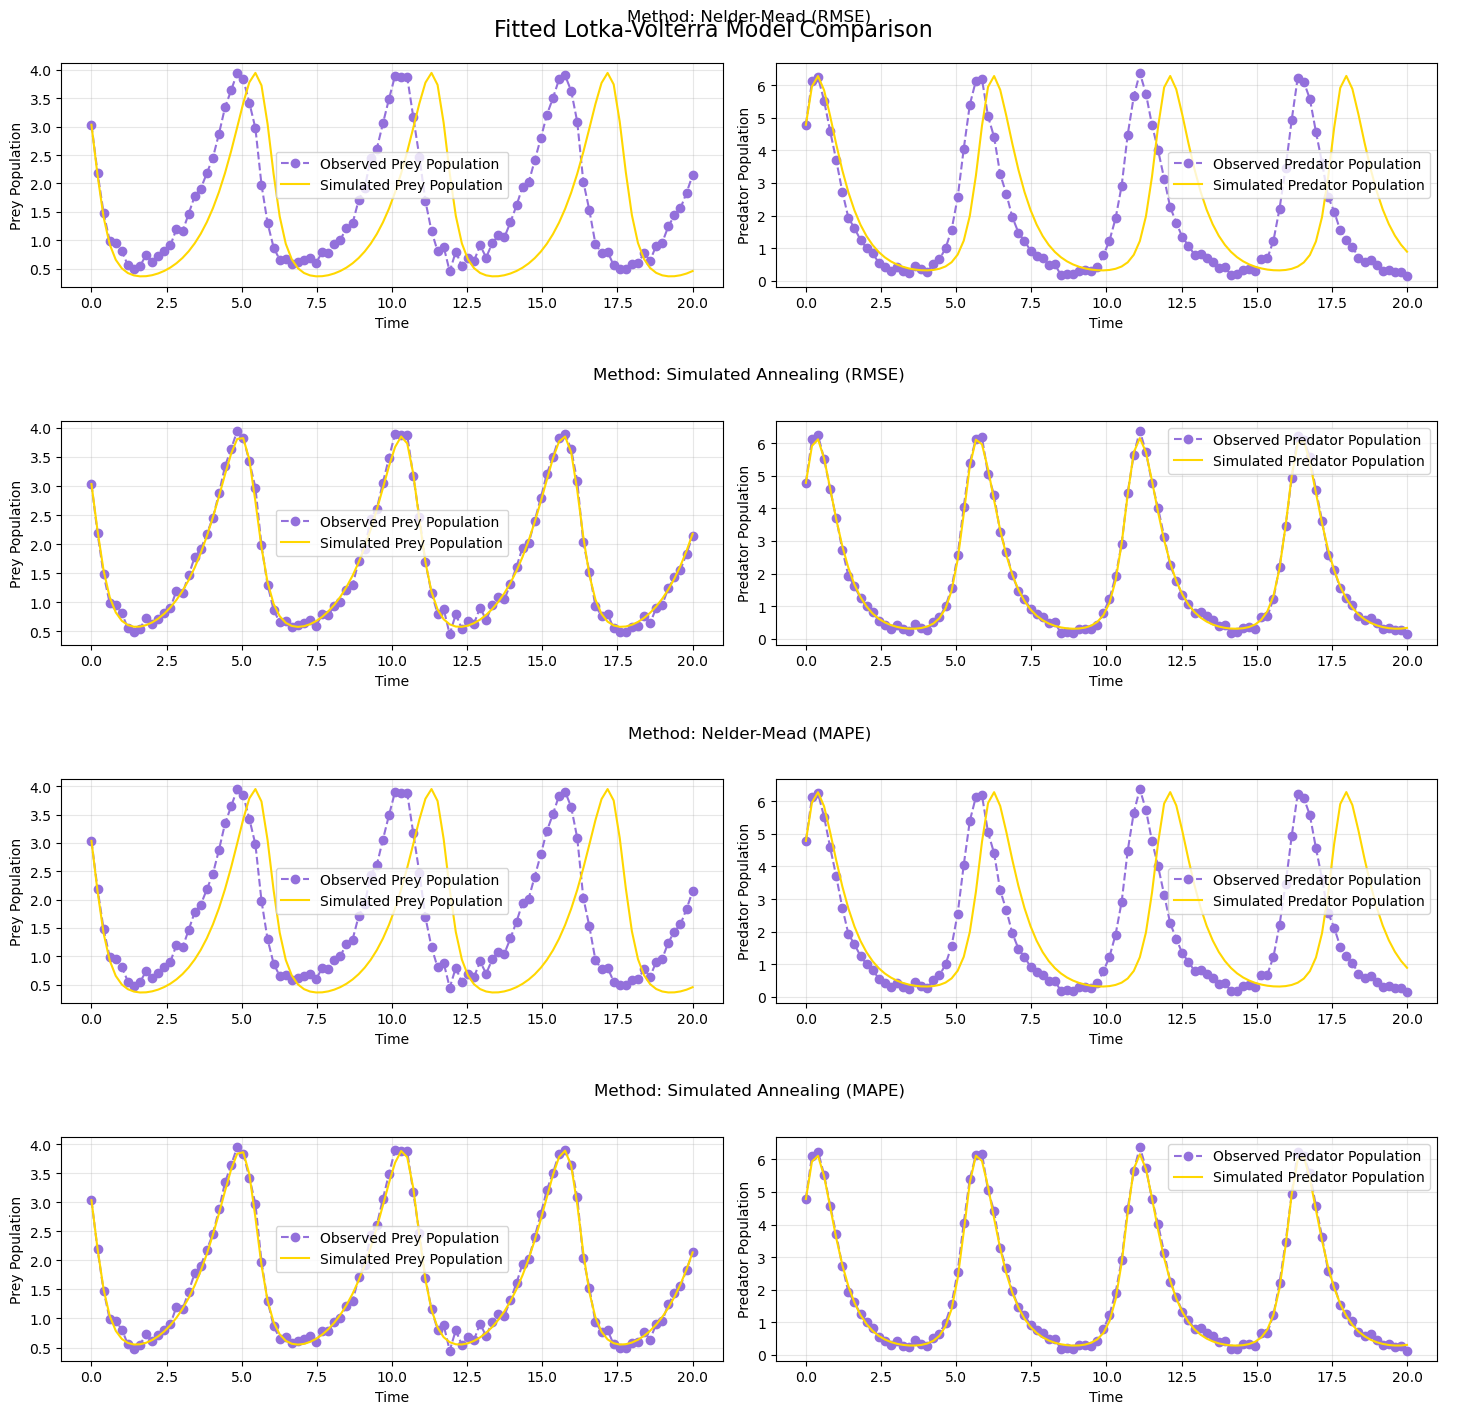


Parameters for Nelder-Mead (RMSE):
[1.  0.5 1.5 1. ]

Parameters for Simulated Annealing (RMSE):
[0.85987211 0.43969729 2.         1.15808812]

Parameters for Nelder-Mead (MAPE):
[1.  0.5 1.5 1. ]

Parameters for Simulated Annealing (MAPE):
[0.86925781 0.45357974 1.99722514 1.16974815]


In [14]:
# Run all optimizations and simulations
optimized_params_local_RMSE = local_optimization_RMSE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_global_RMSE = global_optimization_RMSE(bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_local_MAPE = local_optimization_MAPE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_global_MAPE = global_optimization_MAPE(bounds, t_obs, init_cond, x_obs, y_obs)

sim_data_local_RMSE = simulate_model(optimized_params_local_RMSE, init_cond, t_obs)
sim_data_global_RMSE = simulate_model(optimized_params_global_RMSE, init_cond, t_obs)
sim_data_local_MAPE = simulate_model(optimized_params_local_MAPE, init_cond, t_obs)
sim_data_global_MAPE = simulate_model(optimized_params_global_MAPE, init_cond, t_obs)

# Create the main figure
fig = plt.figure(figsize=(15, 15))

# Add a main title to the figure
fig.suptitle("Fitted Lotka-Volterra Model Comparison", fontsize=16, y=0.95)

# Create subplots for each method
methods = [
    ("Nelder-Mead (RMSE)", sim_data_local_RMSE),
    ("Simulated Annealing (RMSE)", sim_data_global_RMSE),
    ("Nelder-Mead (MAPE)", sim_data_local_MAPE),
    ("Simulated Annealing (MAPE)", sim_data_global_MAPE)
]

# Create a grid of subplots (2x2)
for i, (method, sim_data) in enumerate(methods):
    # Create two subplots side by side for each method
    ax1 = plt.subplot(4, 2, 2*i + 1)  # Left subplot (prey)
    ax2 = plt.subplot(4, 2, 2*i + 2)  # Right subplot (predator)
    
    plot_diffs_subplot(ax1, ax2, method, t_obs, x_obs, y_obs, 
                      sim_data[0], sim_data[1])
    
    # Add method title centered above both plots
    fig.add_subplot(4, 1, i+1, frameon=False)  # Create an invisible subplot spanning both columns
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)  # Make it invisible
    plt.title(f"Method: {method}", pad=30)

plt.tight_layout()
# Adjust layout to make room for the main title
plt.subplots_adjust(top=0.92)
plt.show()

# Print optimized parameters
for method, params in zip(methods, [optimized_params_local_RMSE, 
                                  optimized_params_global_RMSE,
                                  optimized_params_local_MAPE, 
                                  optimized_params_global_MAPE]):
    print(f"\nParameters for {method[0]}:")
    print(params)

c:\Users\magggien\anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


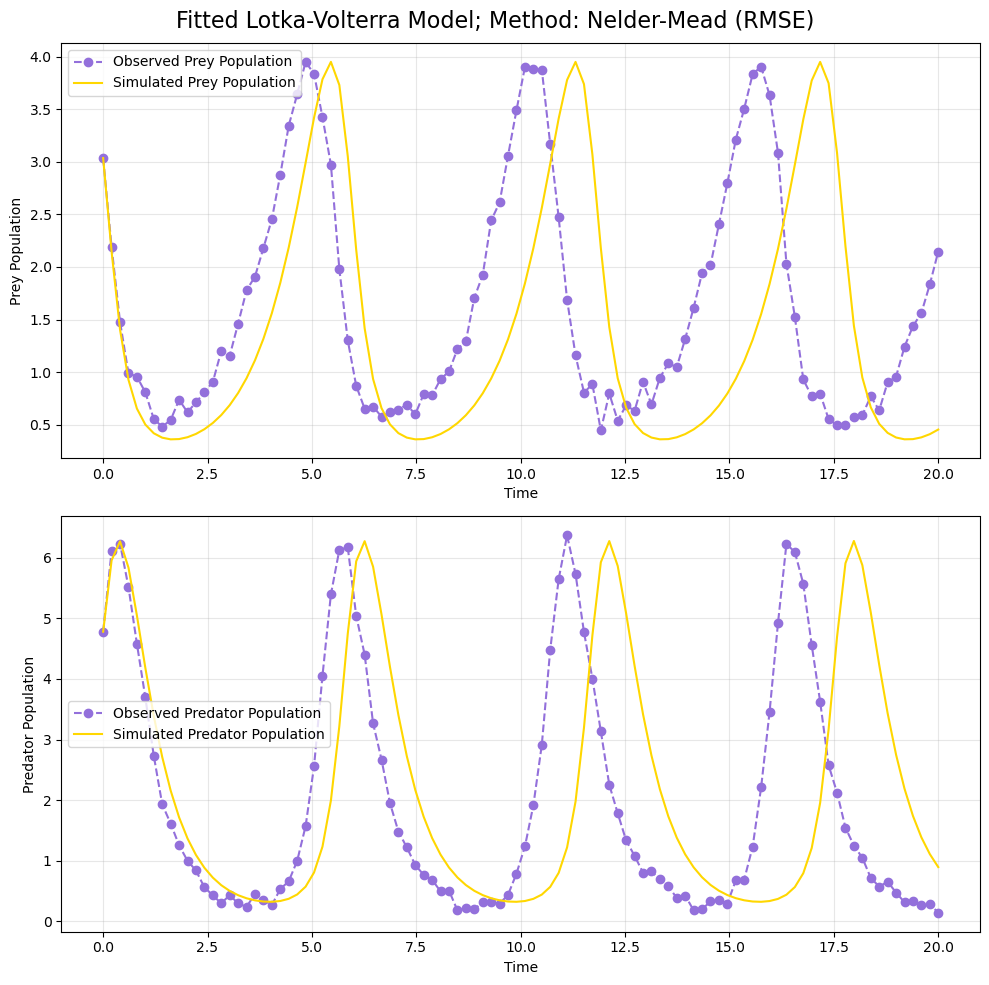

[1.  0.5 1.5 1. ]


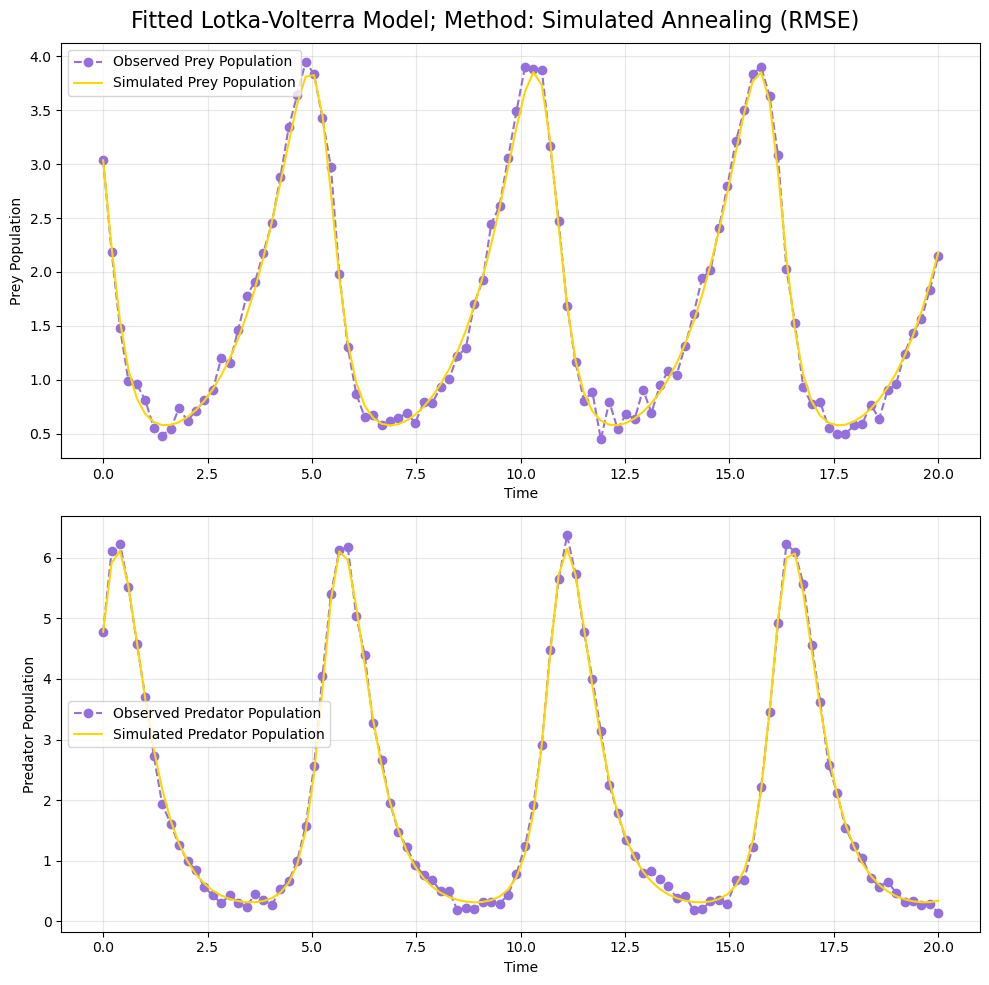

[0.85987211 0.43969729 2.         1.15808812]


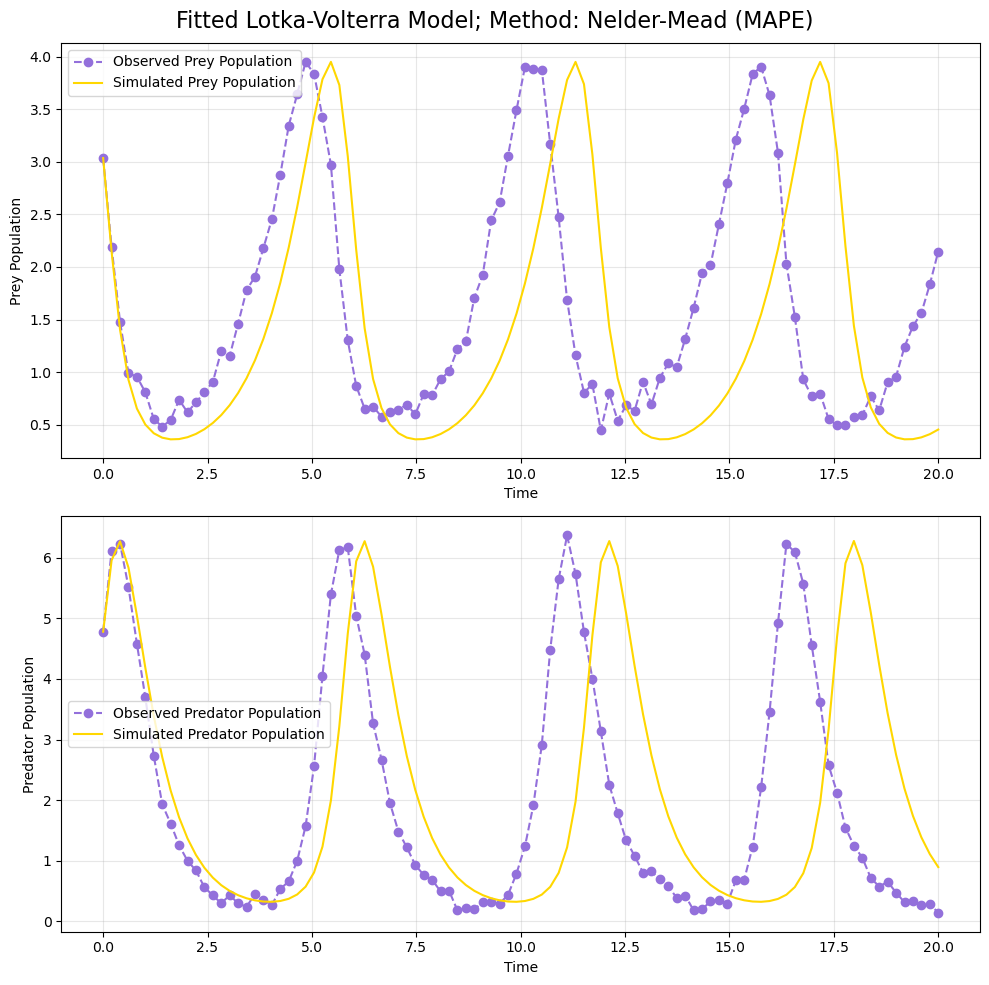

[1.  0.5 1.5 1. ]


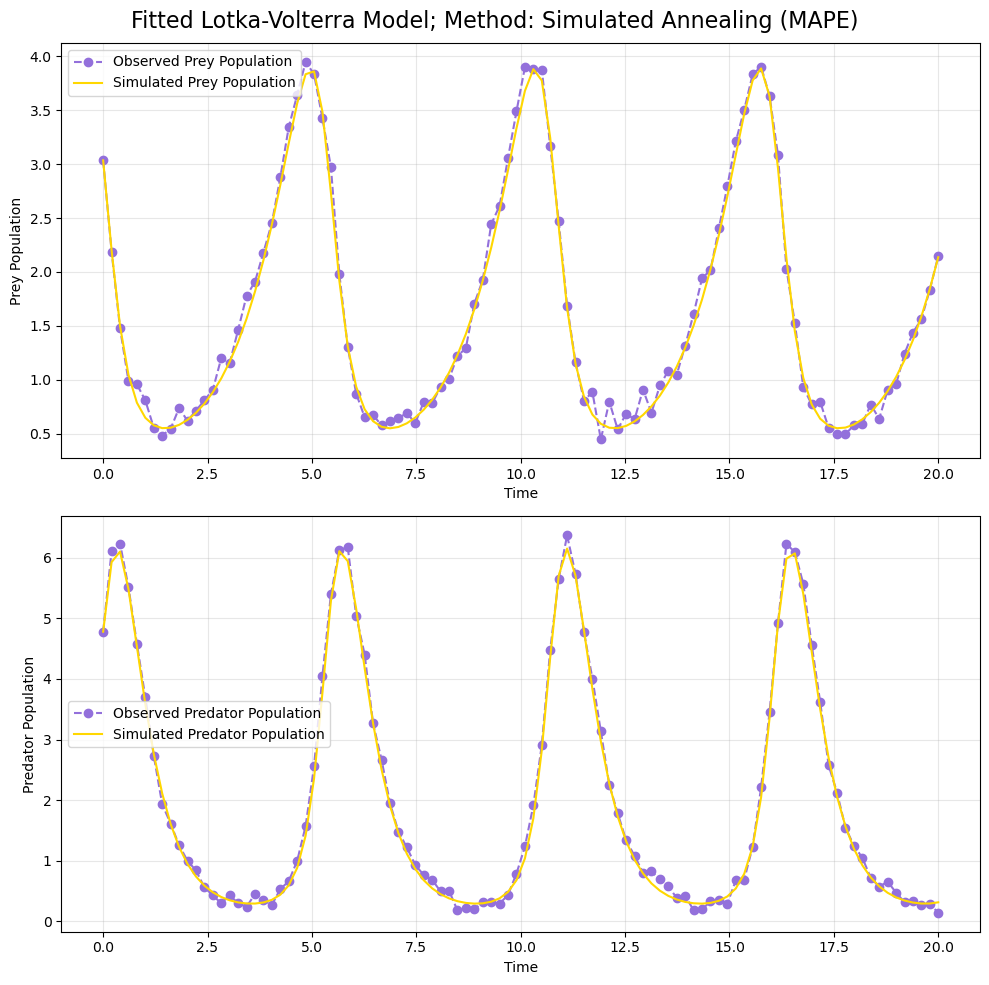

[0.86925781 0.45357974 1.99722514 1.16974815]


In [6]:
# optimized_params_local_RMSE = local_optimization_RMSE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
# optimized_params_global_RMSE = global_optimization_RMSE(bounds, t_obs, init_cond, x_obs, y_obs)
# optimized_params_local_MAPE = local_optimization_MAPE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
# optimized_params_global_MAPE = global_optimization_MAPE(bounds, t_obs, init_cond, x_obs, y_obs)

# sim_data_local_RMSE = simulate_model(optimized_params_local_RMSE, init_cond, t_obs)
# sim_data_global_RMSE = simulate_model(optimized_params_global_RMSE, init_cond, t_obs)
# sim_data_local_MAPE = simulate_model(optimized_params_local_MAPE, init_cond, t_obs)
# sim_data_global_MAPE = simulate_model(optimized_params_global_MAPE, init_cond, t_obs)

# method = "Nelder-Mead (RMSE)"
# plot_diffs(method, t_obs, x_obs, y_obs, sim_data_local_RMSE[0], sim_data_local_RMSE[1])
# print(optimized_params_local_RMSE)
# method = "Simulated Annealing (RMSE)"
# plot_diffs(method, t_obs, x_obs, y_obs, sim_data_global_RMSE[0], sim_data_global_RMSE[1])
# print(optimized_params_global_RMSE)
# method = "Nelder-Mead (MAPE)"
# plot_diffs(method, t_obs, x_obs, y_obs, sim_data_local_MAPE[0], sim_data_local_MAPE[1])
# print(optimized_params_local_MAPE)
# method = "Simulated Annealing (MAPE)"
# plot_diffs(method, t_obs, x_obs, y_obs, sim_data_global_MAPE[0], sim_data_global_MAPE[1])
# print(optimized_params_global_MAPE)

# def combined_removal(t_obs, x_obs, y_obs, init_cond, bounds, tol):
    
#     i = 0
#     while i < len(t_obs) :
#         # Removing the i-th time point and corresponding prey observation
#         t_reduced = t_obs[i:]
#         y_reduced = y_obs[i:]
#         x_reduced = x_obs[i:]
#         # Fitting the parameters to the model using the reduced dataset
#         print(len(t_reduced))
#         optimized_params = global_optimization_RMSE(bounds, t_reduced, init_cond, x_reduced, y_reduced)
        
#         combined_rmse = compute_combined_rmse(optimized_params, t_reduced, init_cond, x_reduced, y_reduced)
        
#         if combined_rmse > tol:
#             print(f"Stopping: RMSE exceeded threshold of {tol}.")
#             break
        
#         print(f"RMSE after removing {combined_rmse} time points = {combined_rmse:.4f}")
#         i += 1
# combined_removal(t_obs, x_obs, y_obs, init_cond, bounds, tol = 1)

# num_points_to_remove = 20
# t_reduced, x_reduced, removed_indices = remove_random_points(t_obs, x_obs, num_points_to_remove)
# x_interpolated = [interpolate_points(t_reduced, t_obs, x_reduced, index) for index in removed_indices]

# def one_removal(t_obs, x_obs, y_obs, init_cond, bounds, tol):
#     i =30

#     while (i<len(t_obs)):
#         t_reduced, x_reduced, removed_indices = remove_random_points(t_obs, x_obs, num_points = i)
#         interpolated_x = x_obs.copy()
#         for index in removed_indices:
#             interpolated_x = interpolate_points(t_reduced, t_obs, x_reduced, interpolated_x, index)
#             print(len(interpolated_x)) 
#         break
#     for idx in range(len(t_obs)):
#         print(t_obs[idx], interpolated_x[idx])

# one_removal(t_obs,x_obs,y_obs,init_cond,bounds,tol =1)